In [1]:
df_train = pd.read_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/df_review_train.csv')
from tqdm import tqdm
df_user = pd.read_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/user_attributes.csv')
df_user_review = df_user.copy()
for i,url in tqdm(enumerate(df_user['url'])):
    df_user_train = df_train[df_train['url']==url]
    review_all = ''
    for review in df_user_train['review']:
        review_all+=review
    df_user_review.loc[i, 'review'] = review_all

df_user_review.head()
df_user_review.to_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/df_user_review.csv')

27094it [31:07, 14.51it/s]


In [2]:
len_review = []
for r in df_user_review['review']:
    len_review.append(len(r))

(array([2.6657e+04, 3.0400e+02, 8.0000e+01, 2.4000e+01, 8.0000e+00,
        7.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 5.0000e+00]),
 array([2.050000e+02, 2.943430e+04, 5.866360e+04, 8.789290e+04,
        1.171222e+05, 1.463515e+05, 1.755808e+05, 2.048101e+05,
        2.340394e+05, 2.632687e+05, 2.924980e+05]),
 <BarContainer object of 10 artists>)

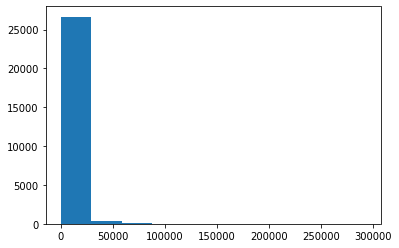

In [3]:
plt.hist(np.array(len_review))

In [4]:
for i in tqdm(range(len(df_user_review))):
    df_user_review.loc[i, 'review_short'] = df_user_review.loc[i, 'review'][:10000]

100%|██████████| 27094/27094 [00:27<00:00, 977.83it/s] 


In [6]:
from janome.analyzer import Analyzer
from janome.tokenfilter import POSKeepFilter,TokenCountFilter, CompoundNounFilter
from janome.charfilter import RegexReplaceCharFilter, UnicodeNormalizeCharFilter
from tqdm import tqdm
tqdm.pandas()
def tokenize_text(df,column='text_joined', hinshi=['名詞','形容詞','動詞']):
    '''
    columnのtextをトークナイズする
    '''
    print('start tokenize')
    #df = self.df_experience
    def join_nouns(text):
        if pd.isna(text):
            return None
        char_filters = [
            UnicodeNormalizeCharFilter(),
            RegexReplaceCharFilter('[#!:;<>{}・`.,()-=$/_\d\'"\[\]\|年月日~]+', ' '),
        ]
        token_filters = [
            POSKeepFilter(hinshi),
            #CompoundNounFilter()
            #TokenCountFilter(),
        ]
        analyzer = Analyzer(char_filters = char_filters, token_filters = token_filters)
        token_nouns = analyzer.analyze(text)
        token_nouns = [l.surface for l in token_nouns]
        joint_nouns = (' ').join(token_nouns)
        return joint_nouns
    df['tokenized_text']=df[column].progress_apply(join_nouns)
    #df.to_csv(self.df_experience_path)
    #self.df_experience = df
    print('end tokenize')
    return df

df_user_review = tokenize_text(df_user_review, column='review_short')

start tokenize


100%|██████████| 27094/27094 [2:00:23<00:00,  3.75it/s]  

end tokenize


In [7]:
df_user_review.to_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/df_user_review.csv')

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_threshold(df, column='tokenized_text', threshold=0.1, save= True, return_words=False):
    '''
    columnの単語列をtf-idfする
    '''
    print('start tfidf_threshold')
    #df = self.df_experience
    df=df.fillna({'tokenized_text':''})
    tfidf = TfidfVectorizer(min_df=3,max_df=0.5)
    tfidf_vec = tfidf.fit_transform(df[column]).toarray()
    feature_names = np.array(tfidf.get_feature_names())
    print(feature_names[:5])
    edges = np.array(np.where(tfidf_vec>threshold))
    print(edges.shape)
    print('end tfidf threshold')
    return feature_names, edges

feature_names, tfidf_words = tfidf_threshold(df_user_review)
print(tfidf_words)

start tfidf_threshold


/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/study_group/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa' 'aaa' 'ab' 'abab' 'abc']
(2, 576417)
end tfidf threshold
[[    0     0     0 ... 27093 27093 27093]
 [ 3903  5739  7418 ... 45983 46051 47767]]


In [14]:
for i,w in enumerate(feature_names[tfidf_words[1]]):
    print(w)


array(['すく', 'はずせ', 'よく', ..., '選ぶ', '那智', '青島'], dtype='<U17')